# Density Estimation: Practical Lesson
### Data Science I
##### Cristobal Donoso
##### Thanks to Guillermo Cabrera
September 28, 2018

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns; sns.set()

## Introduction

In this tutorial we will use Astronomical Data from SDSS 

In [2]:
df = pd.read_csv('guille/data/SDSS_Gals.csv')
df.head()

,z,petroRad_r_kpc,absPetroMag_r
0,0.123945,16.159371,-21.933832
1,0.091500,10.336046,-21.383353
2,0.077116,15.770359,-21.973098
3,0.185233,18.595973,-21.888694
4,0.094941,8.508556,-21.342373


The goal of density estimation is to build a probability density function by using data.

<img src='guille/images/density_estimation.png' />

The most straightforward way is to use **Histogram**

### 1.1 Histogram

In [3]:
z = np.array(df['z'])
print(min(z), max(z))

(0.00011789927, 0.33818287)


In [4]:
np.linspace(min(z),max(z), 5)

array([1.17899270e-04, 8.46341420e-02, 1.69150385e-01, 2.53666627e-01,
       3.38182870e-01])

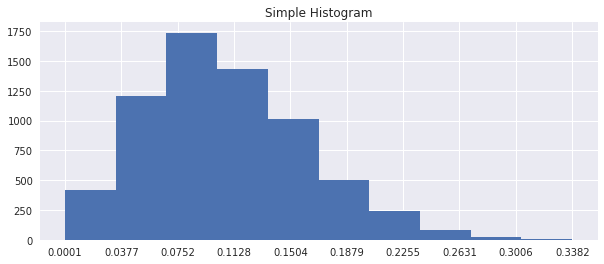

[ 421. 1207. 1737. 1430. 1014.  504.  240.   79.   26.    4.]


In [5]:
plt.figure(figsize=(10,4))
n, _, _ = plt.hist(z, bins = 10)
plt.title('Simple Histogram')
plt.xticks(np.linspace(min(z),max(z), 10))
plt.show()
print(n) #The values of the histogram bin

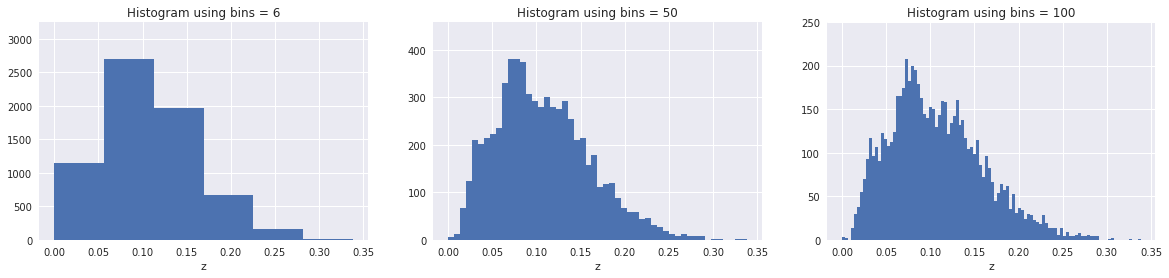

In [6]:
bins = [6, 50, 100]

plt.figure(figsize=(20,4))
for index, b in enumerate(bins):
    pos = int(str(13)+str(index+1))
    plt.subplot(pos)
    
    n, _, _ = plt.hist(z, bins = b)
    plt.plot (z, np.ones(len(z))*n.max()*1.1, "x", alpha = 0.01)
    plt.title('Histogram using bins = '+str(b))
    plt.ylim([0, n.max()*1.2])
    plt.xlabel("z")
plt.show()

In order to improve the estimation: 
- each point could have it’s own bin. 
- We also allow the bins to overlap. 
- Each point is replaced by a box of unit height and some predefined width

The box is usually named **KERNEL**

### 1.2 Kernel Density Estimation

* "Non-parametric” density estimation.
* Each data point is described by a kernel.
* The probability density function is estimated as the sum of the kernels
* $\hat{f}_h(x) = \frac{1}{n}\sum K_h(x-x_i) = \frac{1}{nh}\sum K(\frac{x-x_i}{h})$
* $h$ is the badwidth parameter that defines the size of the Kernel. 

<img style='float: left;' src='./guille/images/KDE1.png'>
<img style='float: right;' src='./guille/images/KDE2.png'>

In [7]:
from sklearn.neighbors import KernelDensity

#### Available Kernels
<img  height="150" width="450" style='float: right;' src='./guille/images/kernels.png'>
<p style='float: left;'>
- Gaussian kernel $\rightarrow$ (kernel = 'gaussian')<br><br>
- Tophat kernel $\rightarrow$ (kernel = 'tophat')<br><br>
- Epanechnikov kernel $\rightarrow$ (kernel = 'epanechnikov')<br><br>
- Exponential kernel $\rightarrow$ (kernel = 'exponential')<br><br>
- Linear kernel $\rightarrow$ (kernel = 'linear')<br><br>
- Cosine kernel $\rightarrow$ (kernel = 'cosine')<br><br>
</p>

In [8]:
kde = KernelDensity(kernel='gaussian',bandwidth = 1e-2)
kde.fit(z[:, None])

KernelDensity(algorithm='auto', atol=0, bandwidth=0.01, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

Mathematically, a kernel is a positive function $K(x;h)$ which is controlled by the bandwidth parameter $h$. Given this kernel form, the density estimate at a point  within a group of points $x_i,\ i = 1,...,N$ is given by:
<center>$
\begin{equation}
p_K(x) = \sum_{i=1}^NK(\frac{x-x_i}{h})
\end{equation}
$</center>

In [9]:
x = np.arange(0, 0.5, 0.01)
# score_samples returns the log of the probability density
prob = np.exp(kde.score_samples (x[:, None]))

How do we choose the number of bins / bins size?
* Assuming an underlying Gaussian distribution: Scott's rule: $h=3.5\sigma/N^{1/3}$, where $\sigma$ is the sample standard deviation and $N$ the number of data points.
* non-Gaussian distributions: Freedman-Diaconis rule: $h= 2(q_{75}-q_{25})/N^{1/3}$, where $q_{75}$ and $q_{25}$ are quartiles 75 and 25 respectively.
* cross-validation (much more expensive).


In [10]:
# histogram "Scott's rule"
dh = 3.5 * z.std()/(len(z)**(1./3.))
bins = np.round((z.max() - z.min())/dh).astype(int)
print ("bins = ", bins)

('bins = ', 34)


/home/koskovi/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


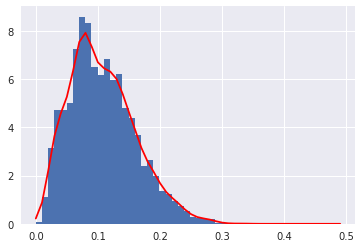

In [11]:
plt.clf()
plt.hist(z, bins = bins, normed=True)
plt.plot(x, prob, "r")
plt.show()

## Selecting $h$ using cross-validation
Given n data points in the original sample then, n-p samples are used to train the model and p points are used as the validation set. This is repeated for all combinations in which original sample can be separated this way, and then the error is averaged for all trials, to give overall effectiveness (*).
### Mean integrated square error

As we noticed, the value of $h$ can have a big impact on our probability density function. In order to select a suitable bandwidth $h$, we minimize the mean integrated squared error (mise):

MISE$_h$ = $\int(\hat{f}_h(x) - f(x))^2dx = \int\hat{f}_h^2dx - 2\int\hat{f}_hf(x)dx + \int f^2(x)dx$

* $\int\hat{f}_h^2dx$ computable from the data
* $\int f^2(x)dx$ does not depend on $h$
* $\int\hat{f}_hf(x)dx = \mathbb{E}_x(\hat{f}_h(x))$, where the expectation is computed with respect to an additional and independent observation $x$.

In order to estimate this last term, we define the _leave one out_ estimate 

$\hat{\mathbb{E}}_x(\hat{f}_h(x)) =  \frac{1}{n}\sum_{i = 1}^n \hat{f}_{h, -i}(x_i)$,

where $\hat{f}_{h, -i}(x)$ is the estimated density leaving out the $i$th data point. Using all this we can define the _cross-validation least-square score_

$CV(h) = \int\hat{f}_h^2(x)dx -\frac{2}{n}\sum_{i = 1}^n \hat{f}_{h, -i}(x_i)$,

and the optimum value of $h$ is found by

$\hat{h}_CV = $argmin$_h CV(h)$.

### Likelihood cross-validation

When doing density estimation we are actually estimating the pdf of our parameters. In that sense, we can use our test set (leave-one-out) to directly estimate the likelihood of that set of points. If we consider the likelihood cost for KDE, for which we have the leave-one-out likelihood cross-validation, then the cost is simply the sum over all points in the data s et (i.e., i = 1, . . . , N ) of the log of the likelihood of the density, where the density,
$\hat{f}_{h,−i} (x_i)$, is estimated leaving out the i th data point.

$CV_l(h) = \frac{1}{N}\sum_{i=1}^N\log{\hat{f}_{h,−i} (x_i)}$

and the optimum value of $h$ is found by

$\hat{h}_CV_l = $argmax$_h CV_l(h)$.

In [12]:
from sklearn.model_selection import GridSearchCV 

#z = np.array(df['z'])
z = np.array(df.sample(100)['z'])

# Use grid search cross-validation to optimize the bandwidth
# Exhaustive search over specified parameter values for an estimator.
params = {'bandwidth': np.logspace(-3, 0, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(z[:, None])

# We extract just the scores (total log probability under the model.)
scores = [x[1] for x in grid.grid_scores_]
scores

/home/koskovi/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[-1646.7603606084938,
 -764.4266948836464,
 -338.4123498396246,
 -132.95941971182742,
 -34.27288835974209,
 12.763435898027879,
 35.025720672010394,
 45.56133183301653,
 50.32985016343675,
 51.84541096344298,
 51.16772402262755,
 48.581238392367226,
 43.71719532488275,
 36.368920334485864,
 27.01331831311685,
 16.368389211936087,
 4.998715128714987,
 -6.749642611007008,
 -18.68833640253441,
 -30.7208165320117]

In [13]:
grid.best_estimator_.bandwidth

0.026366508987303583

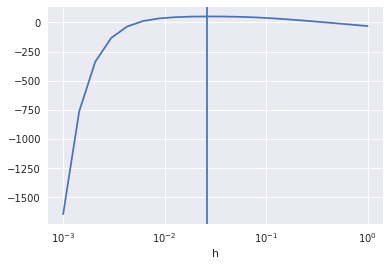

In [14]:
plt.clf()
plt.plot(params['bandwidth'], scores)
plt.xlabel ("h")
plt.axvline(grid.best_estimator_.bandwidth)
plt.xscale("log")
plt.show()

/home/koskovi/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


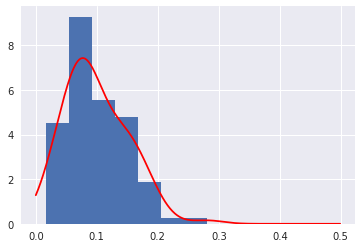

In [15]:
x = np.arange(0, 0.5, 0.001)
pdf = np.exp(grid.best_estimator_.score_samples(x[:, None]))

# histogram "Scott's rule"
dh = 3.5 * z.std()/(len(z)**(1./3.))
b = int(np.round((z.max() - z.min())/dh))

plt.clf()
plt.hist(z, bins = b, normed = True)
plt.plot(x, pdf, "r")
plt.show()

Lets do something a bit more interesting: density of galaxies in terms of their radius and magnitude (and redshift).

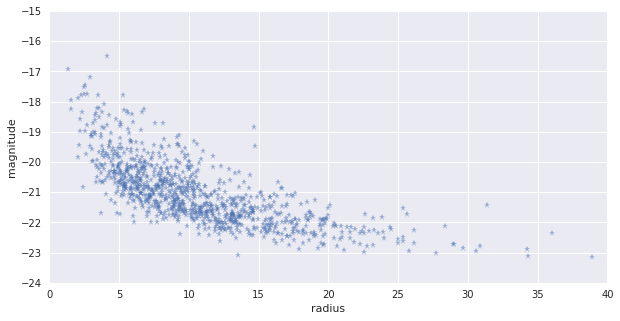

In [28]:
sample_1000 = df.sample(1000)
data = np.array([sample_1000['petroRad_r_kpc'], sample_1000['absPetroMag_r']]).transpose()

plt.figure(figsize=(10,5))
plt.plot(data[:, 0], data[:, 1], '*', alpha=0.5)
plt.xlim([0, 40])
plt.ylim([-24, -15])
plt.xlabel("radius")
plt.ylabel("magnitude")
plt.show()


In [75]:
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-3, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

x = np.arange(.0, 40, 1)
y = np.arange(-24, -15, 0.2)

X, Y = np.meshgrid(x, y)
XY = np.array([X.flatten(), Y.flatten()]).transpose()

pdf = np.exp(grid.best_estimator_.score_samples (XY)).reshape(X.shape)


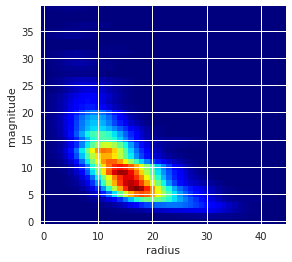

In [76]:
plt.figure()
plt.imshow(pdf.transpose(), interpolation='none', cmap=plt.cm.jet, origin='lower',clip_on=True)
plt.xlabel("radius")
plt.ylabel("magnitude")
plt.show()
    

KernelDensity(algorithm='auto', atol=0, bandwidth=0.5455594781168515,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)
(1000, 2) [ 20.94591031 -21.45474198]


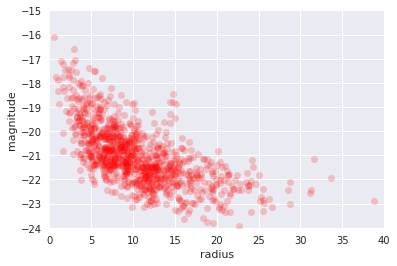

In [77]:
# Once the model is fitted we can even sample from it!
print grid.best_estimator_
new_data = grid.best_estimator_.sample(1000, random_state=0)
print new_data.shape, new_data[0]

plt.clf()
plt.plot(new_data[:, 0], new_data[:, 1], "ro", alpha = 0.2)
plt.xlabel("radius")
plt.ylabel("magnitude")
plt.xlim([0, 40])
plt.ylim([-24, -15])
plt.show()


## Gaussian Mixture Model

<img src="guille/images/GMM1.png" style="height: 200px;"><img src="guille/images/GMM2.png" style="height: 200px;"><img src="guille/images/GMM3.png" style="height: 200px;">

latent variable: $z\in \{e_1, \ldots, e_m\}$

$e_1 = (1, 0, 0,\ldots, 0), \cdots, e_m = (0, 0, 0,\ldots, 1)$

$P(z=e_k) = \alpha_k$

$p(\boldsymbol{x}|z = e_k) = N(\boldsymbol{x}|\mu_k, C_k)$

$p(\boldsymbol{x}) = \sum_zp(\boldsymbol{x}|z)P(z) = \sum_z\alpha_kN(\boldsymbol{x}|\boldsymbol{\mu}_k, C_k)$

$P(z=e_k|\boldsymbol{x}) = \frac{\alpha_kN(\boldsymbol{x}|\boldsymbol{\mu}_k, C_k)}{p(\boldsymbol{x})}$

#### Expectation-Maximization

* E-step: calculate the expected joint (data + latent variable) log-likelihood at iteration t.
* M-step: maximize such likelihood in terms of the model parameters.
  $\theta=(\alpha, \{\boldsymbol{\mu}_k\}, \{C_k\})$
  
How?

* $Z ={z_{i,k}}$ describes which Gaussian $k$ generated each sample $\boldsymbol{x}_i$.
* $z_{i,k} = 1$ if Gaussian $k$ emitted $\boldsymbol{x}_i$.
* Expected log-likelihood:

  $\mathbb{E}_Z[\log p(X, Z|\theta)|X, \theta^t]=\sum_{i,k}\mathbb{E}_Z[z_{i,k}|X, \theta^t]\log \alpha_k^t + \mathbb{E}_Z[z_{i,k}|X, \theta^t]\log N(\boldsymbol{x}|\mu_k^t, C_k^t)$

  $\mathbb{E}_Z[z_{i,k}|X, \theta^t]=\frac{\alpha_k^tN(\boldsymbol{x}_i|\mu_k^t, C_k^t)}{\sum_k\alpha_k^tN(\boldsymbol{x}_i|\mu_k^t, C_k^t)}$
* Maximization:

  $\theta^{t+1} = \mathrm{argmin}_\theta[\mathbb{E}_Z[\log p(X, Z|\theta)|X, \theta^t]]$
  
  $\mu_k^{t+1} = \frac{\sum_i \boldsymbol{x}_iP(z_k|\boldsymbol{x}_i, \theta^t)}{\sum_iP(z_k|\boldsymbol{x}_i, \theta^t)}$
  
  $C_k^{t+1} = \frac{\sum_iP(z_k|\boldsymbol{x}_i, \theta^t)(\boldsymbol{x}_i - \boldsymbol{\mu}_i)(\boldsymbol{x}_i - \boldsymbol{\mu}_i)^\top}{\sum_iP(z_k|\boldsymbol{x}_i, \theta^t)}$
  
  $\alpha_k^{t+1} = \frac{1}{N}\sum_iP(z_k|\boldsymbol{x}_i, \theta^t)$
  
How many Gaussians should we use?

## Model Selection

As we have seen before, in order to compare different models, the prefered technique is cross-validation. Nevertheless, there are classical methods that are easy to use and often effective for simple models. Two of those are the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

### Information Criteria

Consider $M$ parameters for the model and $N$ data points.

#### Akaike Information Criterion  

AIC $=2M-2\ln(L)$

* Based on information theory.
* Suppose that the data is generated by some unknown process $f$ and consider two candidate models $\hat{f}_1$ and $\hat{f}_2$. 
* If we knew $f$ we could infer which model is better by using the K-L divergence. But we don't know $f$.
* [Akaike](http://ieeexplore.ieee.org/document/1100705/) showed, that we can estimate, via AIC, how much more (or less) information is lost by $\hat{f}_1$ than by $\hat{f}_2$. 

#### Bayesian Information Criterion 

BIC $= -2\ln(L) + M\ln(M)$

* Asymptotic result derived under the assumptions that the data distribution is in an exponential family.
  * Exponential family: Given a measure $\eta$, we define an _exponential family of probability distributions_ as those  distributions whose density (relative to $\eta$) have the following general form:
  
    $ p(x|\eta) = h(x)\exp(\eta^\top T(x) - A(\eta))$
    
    for given functions $T$ and $h$ and $A(\eta)$ is the logarithm of a normalization factor.
* BIC is estimated from the Bayesian interpretation of the model:
\begin{eqnarray}
   -2\ln p(x|M) & = & -2\ln \int p(x|M, \theta)p(\theta)\\
   & \sim & -2\ln L + M(\ln (N) - \ln(2\pi))
   \end{eqnarray}

In [78]:
from sklearn.mixture import GaussianMixture # sklearn 0.18

In [79]:
N_train = int(0.9*len(data))
data_train = data[:N_train]
data_test = data[N_train:]

In [86]:
Ns = np.arange(20) + 1 
models = [None for i in range(len(Ns))]
for i in range(len(Ns)):
    models[i] = GaussianMixture(Ns[i]).fit(data) # sklearn 0.18
    #print(models[i])

In [87]:
# compute the AIC and the BIC
AIC = [m.aic(data_train) for m in models]
BIC = [m.bic(data_train) for m in models]

# compute the cross-validated log-likelihood
logL = [m.score(data_test).mean() for m in models]

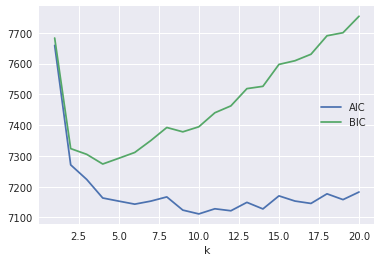

In [88]:
# plot metrics in terms of k
plt.clf()
plt.plot(Ns, AIC, label = "AIC")
plt.plot(Ns, BIC, label = "BIC")
plt.xlabel("k")
plt.legend (loc = "best")
plt.show()

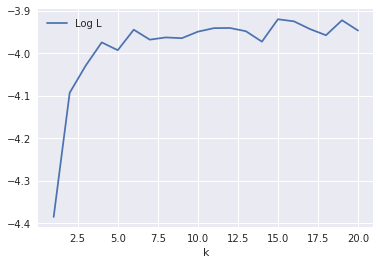

In [89]:
plt.clf()
plt.plot(Ns, logL, label = "Log L")
plt.xlabel("k")
plt.legend (loc = "best")
plt.show()

best model according to BIC with k = 4
((45, 40), (1800, 2))
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
(1800,)


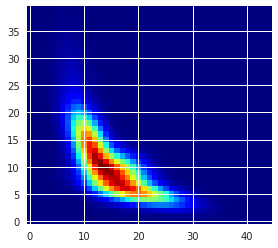

In [90]:
# plot the pdf of the best BIC model
print ("best model according to BIC with k = {0}".format( Ns[np.argmin(BIC)] ))
print (X.shape, XY.shape)
print (models[np.argmin(BIC)])
print (models[np.argmin(BIC)].score_samples (XY).shape)
pdf = np.exp(models[np.argmin(BIC)].score_samples (XY)).reshape(X.shape)

plt.clf()
plt.imshow(pdf.transpose(), interpolation='none', cmap=plt.cm.jet, origin='lower',clip_on=True)
plt.show()

# Excercise: Density Estimation over MNIST

In [106]:
from sklearn import datasets, svm, metrics
# The digits dataset
digits = datasets.load_digits()

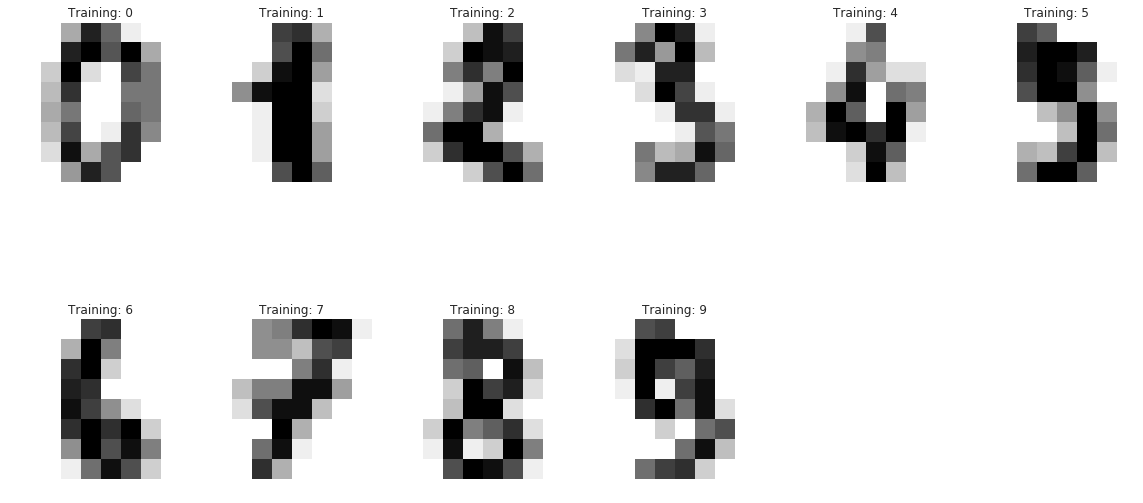

In [104]:
images_and_labels = list(zip(digits.images, digits.target))
plt.figure(figsize=(20,10))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 6, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [115]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [121]:
data.shape

(1797, 64)